In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:

url = 'https://github.com/mattharrison/datasets/raw/master/data/names-ss-1910-2022.csv.zip'
names = pd.read_csv(url)
names

,state,sex,year,name,count
0,ID,F,1910,Mary,53
1,ID,F,1910,Dorothy,31
2,ID,F,1910,Helen,30
3,ID,F,1910,Margaret,24
4,ID,F,1910,Ruth,24
...,...,...,...,...,...
6408036,SD,M,2022,Tristan,5
6408037,SD,M,2022,Tyson,5
6408038,SD,M,2022,Warren,5
6408039,SD,M,2022,Zayne,5


In [3]:
# start = time.time()
# actor_names = [
#     "Primrose", "Anakin", "Arwen", "Esme", "Amelie", "Keanu", "Kylo",
#     "Coraline", "Leia", "Meadow", "Adele", "Elsa", "Augustus", 
#     "Xander", "Maximus", "Arya", "Ariel", "Chandler", "Luna"
# ]

# movies = [
#     "The Hunger Games", "Star Wars", "The Lord of the Rings", "New Moon", 
#     "Amelie", "John Wick", "Star Wars", "Coraline", "Star Wars: A New Hope",
#     "The Sopranos", "21", "Frozen", "The Fault in Our Stars", 
#     "Buffy the Vampire Slayer", "Gladiator", "Game of Thrones", 
#     "The Little Mermaid", "Friends", "Harry Potter and the Order of the Phoenix"
# ]

# years = [
#     2012, 1999, 2001, 2006, 2001, 2014, 2015, 2009, 1977,
#     1999, 2010, 2013, 2014, 1997, 2000, 2011, 1989, 1994, 2007
# ]

# # Creating DataFrame
# movie_names = pd.DataFrame({
#     'Name': actor_names,
#     'Movie': movies,
#     'Year': years
# })
# movie_names

In [4]:
# start = time.time()
# (names
#  #.merge(movie_names, left_on='name', right_on='Name', how='inner')
#  .groupby(['year', 'name'])
#  ['count']
#  .sum()
#  .unstack()
#  .fillna(0)
#  .plot(cmap='viridis')
# )

In [5]:
# import matplotlib.pyplot as plt

# def plot_fill(df_, factor=100, figsize=(8,3), alpha=.8):
#     fig, ax = plt.subplots(figsize=figsize)
#     for i, col in enumerate(df_.columns):
#         ax.plot(df_.index, df_[col] + (i*factor), linewidth=1)
#         ax.fill_between(df_.index, y1=[(i*factor)] * len(df_), y2=df_[col] + (i*factor), alpha=alpha)
#         # add name (movie to the left)
#         ax.text(df_.index[0] -1, (i*factor) + 100, col, fontsize=12, ha='right', va='center')

#     # remove spines
#     for side in ['right', 'top', 'left']:
#         ax.spines[side].set_visible(False)

#     # remove ticks
#     ax.tick_params(axis='both', which='both', bottom=False, left=False)
#     ax.set_yticks([])

#     # set xticks
#     ax.set_xticks(range(-10,11))
#     ax.set_title('Baby Names From Pop Culture', loc='left', fontsize=18)
#     ax.set_xlabel('Year before/after Release', fontsize=14)
#     return df_

# (names
#  #.merge(movie_names, left_on='name', right_on='Name', how='inner')
#  .assign(year_offset=lambda df_: df_.year - df_.Year)
#  .query('year_offset >= -10 and year_offset <= 10')
#  .groupby(['year_offset', 'name'])
#  ['count']
#  .sum()
#  .unstack()
#  .reindex(range(-10,11))
#  .fillna(0)
#  # sort columns by sum of columns
#  .loc[:, lambda df_: df_.sum().sort_values(ascending=False).index]
#  .pipe(plot_fill, factor=-1000, figsize=(6,6))
# )

# end = time.time() - start
# print(end)

Total execution time: 54.87 seconds


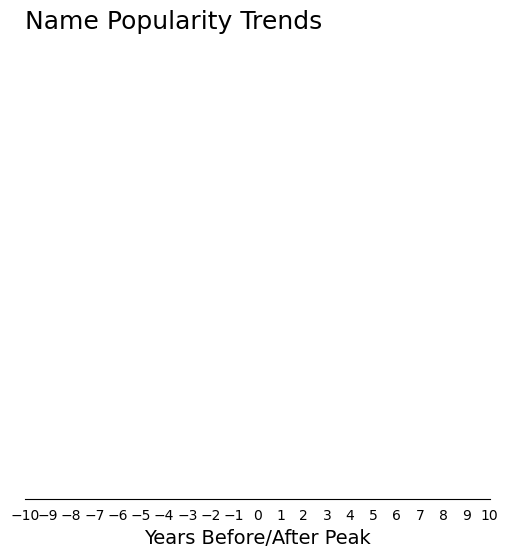

In [6]:
start = time.time()
def complex_analysis(names_df):
    # Calculate rolling statistics for each name
    df = (names_df
          .sort_values(['name', 'year'])
          .assign(
              # Rolling means with different windows
              rolling_mean_5 = lambda x: x.groupby('name')['count'].transform(lambda y: y.rolling(5, min_periods=1).mean()),
              rolling_mean_10 = lambda x: x.groupby('name')['count'].transform(lambda y: y.rolling(10, min_periods=1).mean()),
              
              # Exponential weighted means
              ewm_mean = lambda x: x.groupby('name')['count'].transform(lambda y: y.ewm(span=5).mean()),
              
              # Percentage changes
              pct_change = lambda x: x.groupby('name')['count'].transform('pct_change'),
              
              # Cumulative statistics
              cumsum = lambda x: x.groupby('name')['count'].transform('cumsum'),
              cummax = lambda x: x.groupby('name')['count'].transform('cummax'),
              
              # Relative position metrics
              rank_pct = lambda x: x.groupby('year')['count'].transform('rank', pct=True),
              
              # Complex calculations
              normalized = lambda x: (x['count'] - x.groupby('name')['count'].transform('mean')) 
                                   / x.groupby('name')['count'].transform('std'),
              
              # Time-based features
              decade = lambda x: (x['year'] // 10) * 10,
              
              # Lagged values
              lag_1 = lambda x: x.groupby('name')['count'].transform(lambda y: y.shift(1)),
              lag_5 = lambda x: x.groupby('name')['count'].transform(lambda y: y.shift(5))
          ))
    
    # Separate aggregations to avoid MultiIndex complications
    agg_count = (df.groupby(['name', 'decade'])['count']
                 .agg(['mean', 'std', 'min', 'max', 'sum'])
                 .reset_index())
    
    agg_normalized = (df.groupby(['name', 'decade'])['normalized']
                     .agg(['mean', 'std'])
                     .reset_index())
    
    agg_rank = (df.groupby(['name', 'decade'])['rank_pct']
                .agg(['mean', 'median'])
                .reset_index())
    
    # Merge aggregations together
    agg_stats = (agg_count
                 .merge(agg_normalized, on=['name', 'decade'])
                 .merge(agg_rank, on=['name', 'decade']))
    
    # Rename columns to avoid conflicts
    agg_stats.columns = [f'{col}_agg' if col not in ['name', 'decade'] else col 
                        for col in agg_stats.columns]
    
    # Merge back to original dataframe
    df = df.merge(agg_stats, on=['name', 'decade'])
    
    # Calculate additional metrics
    df['volatility'] = df['pct_change'].rolling(window=10).std()
    df['momentum'] = df['pct_change'].rolling(window=10).mean()
    
    return df

# Apply complex operations
enriched_names = complex_analysis(names)

# Find peak years for each name
peak_years = (enriched_names.groupby('name')['count']
             .agg(lambda x: x.idxmax())
             .to_dict())

# Select top names based on multiple criteria
top_names = (enriched_names
             .groupby('name')
             .agg({
                 'count': 'max',
                 'normalized': 'max',
                 'rank_pct': 'mean'
             })
             .sort_values('count', ascending=False)
             .head(15)
             .index)

# Create visualization data
viz_data = (enriched_names[enriched_names['name'].isin(top_names)]
            .assign(year_offset=lambda df: df.apply(lambda row: row['year'] - peak_years[row['name']], axis=1))
            .query('year_offset >= -10 and year_offset <= 10')
            .groupby(['year_offset', 'name'])['count']
            .sum()
            .unstack()
            .reindex(range(-10,11))
            .fillna(0)
            .loc[:, lambda df: df.sum().sort_values(ascending=False).index])

# Plotting function
def plot_fill(df_, factor=100, figsize=(8,3), alpha=.8):
    fig, ax = plt.subplots(figsize=figsize)
    for i, col in enumerate(df_.columns):
        ax.plot(df_.index, df_[col] + (i*factor), linewidth=1)
        ax.fill_between(df_.index, y1=[(i*factor)] * len(df_), 
                       y2=df_[col] + (i*factor), alpha=alpha)
        ax.text(df_.index[0] -1, (i*factor) + 100, col, 
                fontsize=12, ha='right', va='center')
    
    for side in ['right', 'top', 'left']:
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_yticks([])
    ax.set_xticks(range(-10,11))
    ax.set_title('Name Popularity Trends', loc='left', fontsize=18)
    ax.set_xlabel('Years Before/After Peak', fontsize=14)
    return df_

# Create visualization
viz_data.pipe(plot_fill, factor=-1000, figsize=(6,6))

# End timing
end = time.time() - start
print(f"Total execution time: {end:.2f} seconds")